In [1]:
%pip install stable-baselines3 gymnasium pandas matplotlib shimmy torch sb3-contrib seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import gymnasium as gym
import numpy as np
import torch as th
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from typing import Callable
import torch.nn as nn

class TrainingMetricsCallback(BaseCallback):
    
    def __init__(self, check_freq: int = 100, verbose=0):
        super(TrainingMetricsCallback, self).__init__(verbose)
        self.check_freq = check_freq # number of episodes we're averaging over for mean reward and game length
        self.ep_rew_means = []
        self.ep_len_means = []
        self.episodes = []
        self.current_episode_count = 0
        
    def _on_step(self) -> bool:
        if len(self.model.ep_info_buffer) == self.check_freq:
            self.current_episode_count += self.check_freq
            
            new_episodes = list(self.model.ep_info_buffer)[:self.check_freq]
            for _ in range(self.check_freq):
                self.model.ep_info_buffer.popleft() # remove episodes we've seen
                
            ep_means = [ep['r'] for ep in new_episodes]
            ep_lens = [ep['l'] for ep in new_episodes]
            
            ep_rew_mean = np.mean(ep_means)
            ep_len_mean = np.mean(ep_lens)
            
            self.ep_rew_means.append(ep_rew_mean)
            self.ep_len_means.append(ep_len_mean)
            self.episodes.append(self.current_episode_count)
            
            if self.verbose > 0:
                print(f"Current episode count: {self.current_episode_count}: "
                        f"Mean reward = {ep_rew_mean:.2f}, Mean length = {ep_len_mean:.2f} for past {self.check_freq} episodes.")
                    
        return True

class BattleshipVisualizer:
    @staticmethod
    def plot_heatmap(model, env, title="Model Preference"):
        obs, _ = env.reset()
        obs_tensor = th.as_tensor(obs).unsqueeze(0).float().to(model.device)
        with th.no_grad():
            dist = model.policy.get_distribution(obs_tensor)
            data = dist.distribution.probs.cpu().numpy()[0]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(data.reshape(10, 10), cmap='viridis', annot=False, cbar_kws={'label': "Action Probability"})
        plt.title(title)
        plt.show()

class BattleshipEvaluator:
    def __init__(self, model, env):
        self.model = model
        self.env = env
        
    def run_evaluation(self, num_games=1000, mask=True):
        winning_moves = []
        ratios = []
        raw_actions = []
        wins = 0
        total_steps = 0
        total_reward = 0
        
        print(f"Running {num_games} games (Masked={mask})...")
        
        for _ in range(num_games):
            obs, _ = self.env.reset()
            done = False
            steps, hits, misses, game_reward = 0, 0, 0, 0
            
            while not done:
                if mask:
                    action, _ = self.model.predict(obs, action_masks=self.env.action_masks(), deterministic=True)
                else:
                    action, _ = self.model.predict(obs, action_masks=None, deterministic=True)
                
                action = int(action)
                if not mask: raw_actions.append(action)
                
                obs, reward, terminated, truncated, _ = self.env.step(action)
                steps += 1
                game_reward += reward
                
                if reward > 0: hits += 1
                else: misses += 1
                
                if terminated:
                    wins += 1
                    winning_moves.append(steps)
                    done = True
                elif truncated:
                    done = True
            
            total_steps += steps
            total_reward += game_reward
            ratios.append(hits / misses if misses > 0 else hits)
            
        return {
            "moves_to_win": winning_moves,
            "ratios": ratios,
            "actions": raw_actions,
            "win_rate": wins / num_games,
            "avg_steps_per_game": total_steps / num_games,
            "avg_reward_per_game": total_reward / num_games,
            "avg_hit_miss_ratio": np.mean(ratios) if ratios else 0.0
        }

    def plot_data(self, masked, unmasked):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Moves to Win (Masked)
        if masked['moves_to_win']:
            sns.histplot(masked['moves_to_win'], kde=True, ax=axes[0,0], color='green', edgecolor='black', alpha=0.5)
            axes[0,0].set_title(f"Moves to Win (Masked) - WR: {masked['win_rate']:.1%}")
        else:
            axes[0,0].text(0.5, 0.5, "No Wins", ha='center', va='center')

        # 2. Moves to Win (Unmasked)
        if unmasked['moves_to_win']:
            sns.histplot(unmasked['moves_to_win'], kde=True, ax=axes[0,1], color='green', edgecolor='black', alpha=0.5)
        axes[0,1].set_title(f"Moves to Win (Unmasked) - WR: {unmasked['win_rate']:.1%}")
        axes[0,1].set_xlim(0, 110)

        # 3. Masked Hit/Miss Ratio
        if masked['ratios']:
            sns.histplot(masked['ratios'], kde=True, ax=axes[1,0], color='blue', edgecolor='black', alpha=0.5)
        axes[1,0].set_title("Hit/Miss Ratio (Masked)")

        # 4. Unmasked Hit/Miss Ratio
        if unmasked['ratios']:
            sns.histplot(unmasked['ratios'], kde=True, ax=axes[1,0], color='blue', edgecolor='black', alpha=0.5)
        axes[1,0].set_title("Hit/Miss Ratio (Unmasked)")

def print_and_save_stats(model, masked_stats, unmasked_stats):
    output = "-----------------------------\n"
    output += f"PPO Model Results (Timesteps: {model.num_timesteps}):\n"
    
    output += "  Action Masking Results:\n"
    output += f"    Win Rate: {masked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {masked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {masked_stats['avg_reward_per_game']:.2f}\n"
    output += f"    Avg Hit/Miss Ratio: {masked_stats['avg_hit_miss_ratio']:.2f}\n"
    
    output += "  Non-Action Masking Results:\n"
    output += f"    Win Rate: {unmasked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {unmasked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {unmasked_stats['avg_reward_per_game']:.2f}\n"
    output += f"    Avg Hit/Miss Ratio: {unmasked_stats['avg_hit_miss_ratio']:.2f}\n"
    
    print(output)
    
    with open("ppo-training.txt", "a") as f:
        f.write(output)
        f.write(f"\tFull Masked Summary: {str(masked_stats)}\n")
        f.write(f"\tFull Unmasked Summary: {str(unmasked_stats)}\n")
    print("Stats saved to ppo-training.txt")


In [3]:

import gymnasium
import numpy as np
from gymnasium import spaces
from copy import deepcopy
from typing import Union
from typing import Tuple
from typing import Optional
from collections import namedtuple
from enum import Enum

Ship = namedtuple('Ship', ['min_x', 'max_x', 'min_y', 'max_y'])
Action = namedtuple('Action', ['x', 'y'])

class CHANNEL_MAP(Enum):
    MISSED = 0 # 0 = not missed, 1 = missed
    HIT = 1 # 0 = not hit, 1 = hit
    LEGAL_MOVE = 2 # 0 = legal move/unknown cell, 1 = illegal move/revealed cell

def is_notebook():
    """Helper used to change the way the environment in rendered"""
    from IPython import get_ipython
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        else:
            return False  # Terminal running IPython or other types
    except NameError:
        return False  # Probably standard Python interpreter


class BattleshipEnv(gymnasium.Env):
    def __init__(self,
                 board_size: Tuple = None,
                 ship_sizes: dict = None,
                 episode_steps: int = 110,
                 reward_dictionary: Optional[dict] = None):

        self.ship_sizes = ship_sizes or {5: 1, 4: 1, 3: 2, 2: 1}
        self.board_size = board_size or (10, 10)

        self.board = None  # Hidden state updated throughout the game
        self.board_generated = None  # Hidden state generated and left not updated (for debugging purposes)
        self.observation = None  # the observation is a (3, n, m) matrix
        self.NUM_CHANNELS = 3
        
        self.done = None
        self.step_count = None
        self.episode_steps = episode_steps

        reward_dictionary = {} if reward_dictionary is None else reward_dictionary
        default_reward_dictionary = reward_dictionary or {  # todo further tuning of the rewards required
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3
        }
        
        self.reward_dictionary = {key: reward_dictionary.get(key, default_reward_dictionary[key]) for key in default_reward_dictionary.keys()}
        self.action_space = spaces.Discrete(self.board_size[0] * self.board_size[1])
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.NUM_CHANNELS, self.board_size[0], self.board_size[1]))
            # three 10x10 matrices stacked together for the convolutional neural network
    
    def get_original_board(self) -> np.ndarray:
        return self.board_generated  
    
    def action_masks(self) -> np.ndarray:
        #get current hits and misses from observation
        # Channel 0 is Missed, Channel 1 is Hit
        missed_mask = self.observation[CHANNEL_MAP.MISSED.value].flatten().astype(bool)
        hit_mask = self.observation[CHANNEL_MAP.HIT.value].flatten().astype(bool)

        occupied = missed_mask | hit_mask
        
        return ~occupied
    
    def _in_horizontal_bounds(self, x: int) -> bool:
        return 0 <= x < self.board_size[0]
    
    def _in_vertical_bounds(self, y: int) -> bool:
        return 0 <= y < self.board_size[1]
    
    def _check_proximal_hit(self, action: tuple[int, int]) -> bool: 
        return (
            (self._in_horizontal_bounds(action.x - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x - 1, action.y] == 1) or
            (self._in_horizontal_bounds(action.x + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x + 1, action.y] == 1) or
            (self._in_vertical_bounds(action.y - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y - 1] == 1) or
            (self._in_vertical_bounds(action.y + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y + 1] == 1)
        )
    
    def step(self, raw_action: Union[int, tuple]) -> Tuple[np.ndarray, int, bool, dict]:
        if isinstance(raw_action, int) or isinstance(raw_action, np.int64):
            assert (0 <= raw_action < self.board_size[0]*self.board_size[1]),\
                "Invalid action (The encoded action is outside of the limits)"
            # action = Action(x=raw_action % self.board_size[0], y=raw_action // self.board_size[0])
            action = Action(x=raw_action // self.board_size[1], y=raw_action % self.board_size[1])

        elif isinstance(raw_action, tuple):
            assert (0 <= raw_action[0] < self.board_size[0] and 0 <= raw_action[1] < self.board_size[1]),\
                "Invalid action (The action is outside the board)"
            action = Action(x=raw_action[0], y=raw_action[1])

        else:
            raise AssertionError("Invalid action (Unsupported raw_action type)")

        self.step_count += 1

        truncated = False

        # Check if the game is done (if true, the current step is the "last step")
        if self.step_count >= self.episode_steps:
            self.done = False
            truncated = True

        
        
        if self.board[action.x, action.y] == 1: # hit ship
            self.board[action.x, action.y] = 0
            self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] = 1
            self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
            
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            # Win (No boat left)
            if not self.board.any():
                self.done = True
                return self.observation, self.reward_dictionary['win'], self.done, truncated, {}
            if self._check_proximal_hit(action):
                return self.observation, self.reward_dictionary['proximal_hit'], self.done, truncated, {}
            
            return self.observation, self.reward_dictionary['hit'], self.done, truncated, {}

        else:
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            
            if self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_missed'], self.done, truncated, {}

            # repeat cell marked as hit 
            elif self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_hit'], self.done, truncated, {}

            # Missed (Action not repeated and boat(s) not touched)
            else:
                self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] = 1
                self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
                
                return self.observation, self.reward_dictionary['missed'], self.done, truncated, {}

    def reset(self, seed=None, options=None) -> np.ndarray:
        self._set_board()
        self.board_generated = deepcopy(self.board)
        self.observation = np.zeros((self.NUM_CHANNELS, *self.board_size), dtype=np.float32)
        self.step_count = 0
        self.done = False
        return self.observation, {}

    def _set_board(self) -> None:
        self.board = np.zeros(self.board_size, dtype=np.float32)
        for ship_size, ship_count in self.ship_sizes.items():
            for _ in range(ship_count):
                self._place_ship(ship_size)

    def _place_ship(self, ship_size: int) -> None:
        can_place_ship = False
        while not can_place_ship:  # todo add protection infinite loop
            ship = self._get_ship(ship_size, self.board_size)
            can_place_ship = self._is_place_empty(ship)
        self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y] = True

    @staticmethod
    def _get_ship(ship_size: int, board_size: tuple) -> Ship:
        if np.random.choice(('Horizontal', 'Vertical')) == 'Horizontal':
            min_x = np.random.randint(0, board_size[0] + 1 - ship_size)
            min_y = np.random.randint(0, board_size[1])
            return Ship(min_x=min_x, max_x=min_x + ship_size, min_y=min_y, max_y=min_y + 1)
        else:
            min_x = np.random.randint(0, board_size[0])
            min_y = np.random.randint(0, board_size[1] + 1 - ship_size)
            return Ship(min_x=min_x, max_x=min_x + 1, min_y=min_y, max_y=min_y + ship_size)

    def _is_place_empty(self, ship: Ship) -> bool:
        return np.count_nonzero(self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y]) == 0

    def render(self, mode='human'):
        board = np.empty(self.board_size, dtype=str)
        board[self.observation[CHANNEL_MAP.MISSED.value] != 0] = '⚫'
        board[self.observation[CHANNEL_MAP.HIT.value] != 0] = '❌'
        self._render(board)

    def render_board_generated(self):
        board = np.empty(self.board_size, dtype=str)
        board[self.board_generated != 0] = '⬛'
        self._render(board)

    @staticmethod
    def _render(board, symbol='⬜'):
        import pandas as pd

        num_rows, num_columns = board.shape
        columns = [chr(i) for i in range(ord('A'), ord('A') + num_columns)]
        index = [i + 1 for i in range(num_rows)]

        dataframe = pd.DataFrame(board, columns=columns, index=index)
        dataframe = dataframe.replace([''], symbol)

        if is_notebook():
            from IPython.display import display
            display(dataframe)
        else:
            print(dataframe, end='\n')

        # todo maybe put the board generated on the right side
        #  https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

In [4]:
class BattleshipCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        n_channels = observation_space.shape[0] 
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        with th.no_grad():
            obs_tensor = th.as_tensor(observation_space.sample()[None]).float()
            conv_output_dim = self.cnn(obs_tensor).shape[1]
        self.linear = nn.Sequential(
            nn.Linear(conv_output_dim, features_dim),
            nn.ReLU()
        )
    def forward(self, obs: th.Tensor) -> th.Tensor:
        features = self.linear(self.cnn(obs.float()))
        return th.nn.functional.layer_norm(features, features.shape)

In [5]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.callbacks import CheckpointCallback

reward_dict = {
    'win': 100,
    'lose': -30,
    'missed': -0.2,
    'hit': 5,
    'proximal_hit': 20,
    'repeat_missed': -20,
    'repeat_hit': -3
}

LOG_DIR = "./ppo_battleship_log/"
#CHECKPOINT_FREQ = 10000  
TOTAL_TIMESTEPS = 200000
callback = TrainingMetricsCallback(check_freq=1000)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,  # Save every 50k steps
    save_path=LOG_DIR,
    name_prefix="ppo_checkpoint"
)

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

# Combine callbacks
from stable_baselines3.common.callbacks import CallbackList
combined_callback = CallbackList([callback, checkpoint_callback])


def mask_fn(env: gym.Env) -> np.ndarray:
    return env.action_masks()

def make_masked_env():
    env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)
    env = ActionMasker(env, mask_fn)
    return env

#create Vectorized Environment
num_envs = 16
env = make_vec_env(
    make_masked_env, 
    n_envs=num_envs, 
    seed=42, 
    monitor_dir=LOG_DIR
)

policy_kwargs = dict(
    features_extractor_class=BattleshipCNN,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=dict(pi=[256, 128], vf=[256, 128]),
    normalize_images=False
)

model = MaskablePPO(
    "CnnPolicy",
    env,
    learning_rate=linear_schedule(0.0003), 
    n_steps=1024,           
    batch_size=256,            
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.1,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1, 
    policy_kwargs=policy_kwargs,
    tensorboard_log=LOG_DIR
)

try:
    print("Starting PPO Training...")
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=combined_callback)
    model.save("ppo_model_final")
    print("Training completed successfully!")
except KeyboardInterrupt:
    print("Training interrupted - saving model...")
    model.save("ppo_model_interrupted")
except Exception as e:
    print(f"Error occurred: {e}")
    model.save("ppo_model_error")


Using cpu device
Starting PPO Training...
Logging to ./ppo_battleship_log/PPO_15
Step 16000 | Avg Rew: 304.41 | Avg Len: 95.47
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.5     |
|    ep_rew_mean     | 304      |
| time/              |          |
|    fps             | 1978     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 16384    |
---------------------------------
Step 32000 | Avg Rew: 303.38 | Avg Len: 96.11
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96          |
|    ep_rew_mean          | 304         |
| time/                   |             |
|    fps                  | 452         |
|    iterations           | 2           |
|    time_elapsed         | 72          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.002825087 |
|    clip_fraction       

Learning Curves


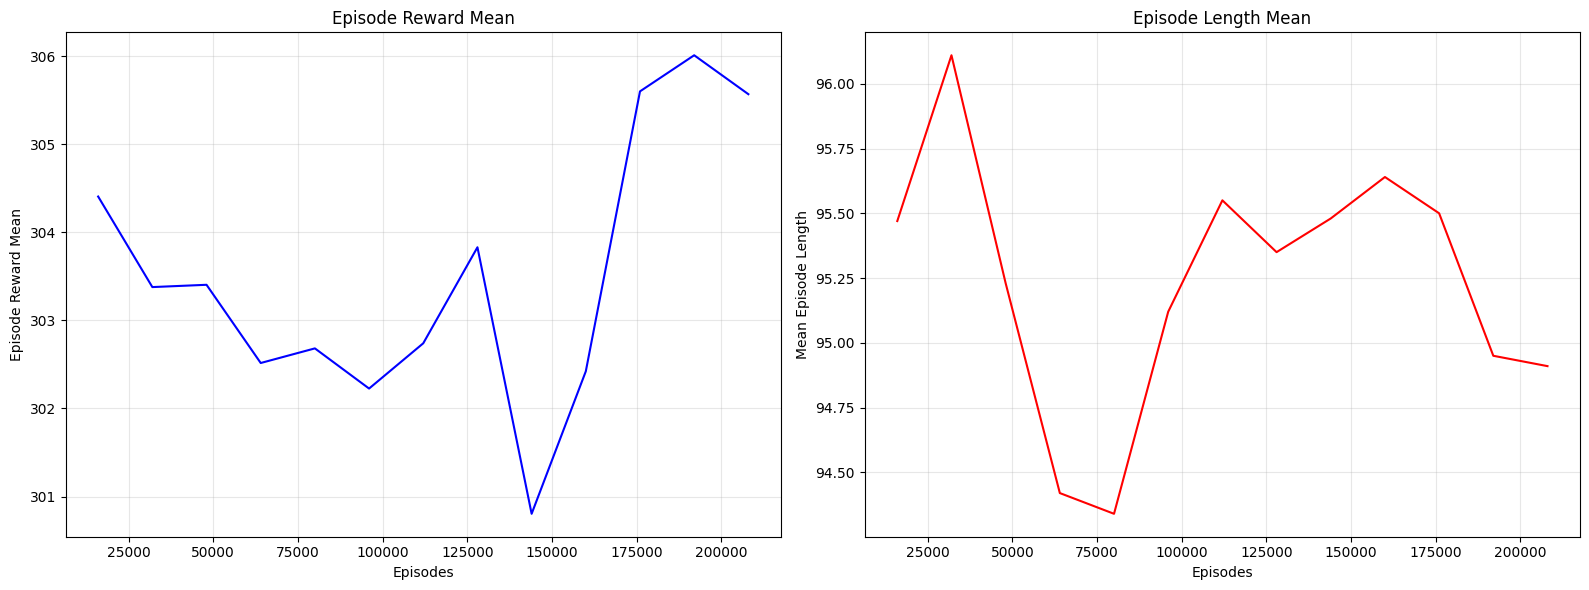

Generating Heatmap...


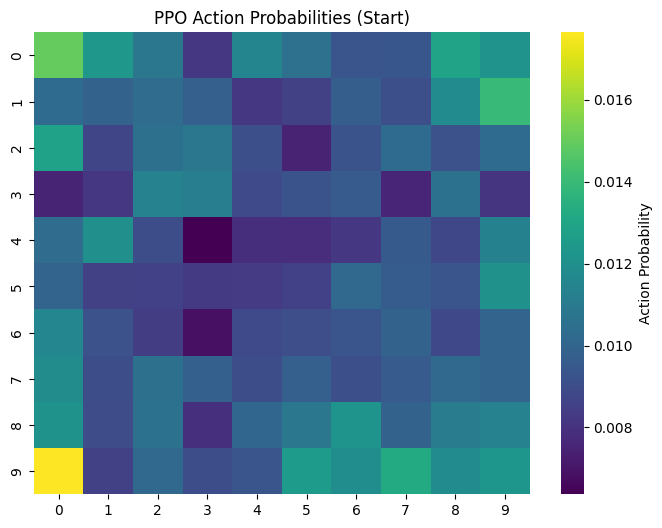

Running Evaluation
Running 1000 games (Masked=True)...
Running 1000 games (Masked=False)...
-----------------------------
PPO Model Results (Timesteps: 212992):
  Action Masking Results:
    Win Rate: 100.00%
    Avg Steps (All Games): 95.55
    Avg Reward: 303.15
    Avg Hit/Miss Ratio: 0.22
  Non-Action Masking Results:
    Win Rate: 0.00%
    Avg Steps (All Games): 110.00
    Avg Reward: -2053.95
    Avg Hit/Miss Ratio: 0.00

Stats saved to ppo-training.txt


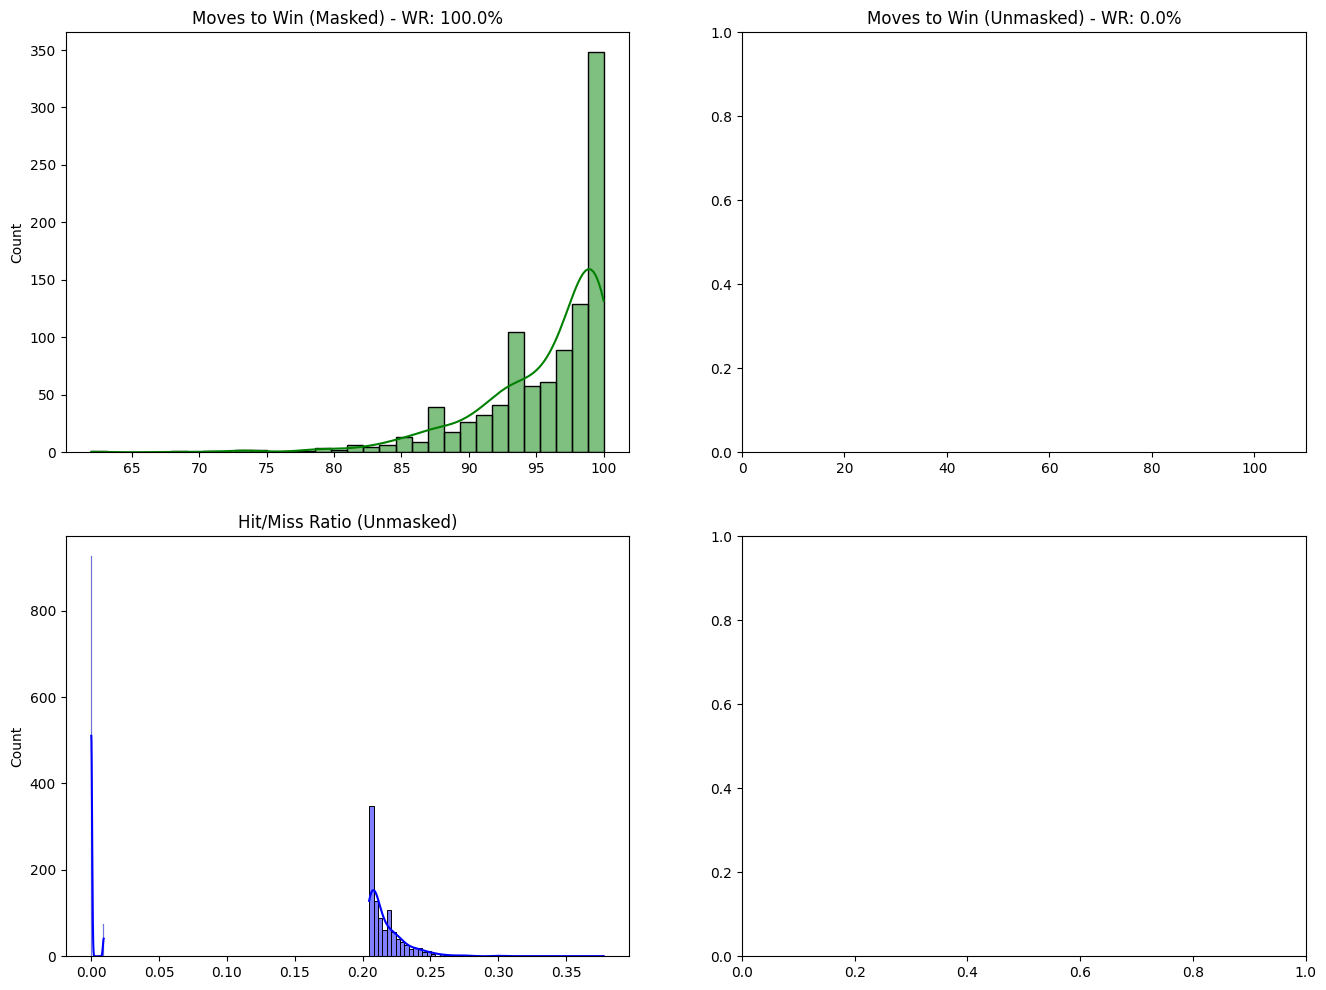

In [9]:


import matplotlib.pyplot as plt

def plot_learning_curves(callback):
    if not callback.episodes or not callback.ep_rew_means:
        print("No training data found in callback yet.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    print("Learning Curves")
    
    #episode numbers
    #episode_numbers = list(range(1, len(callback.ep_rew_means) + 1))
    
    # Plot Reward
    ax1.plot(callback.episodes, callback.ep_rew_means, 'b-')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Episode Reward Mean')
    ax1.set_title(f'Episode Reward Mean')
    ax1.grid(True, alpha=0.3)

    # Plot Episode Length
    ax2.plot(callback.episodes, callback.ep_len_means, 'r-')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Mean Episode Length')
    ax2.set_title(f'Episode Length Mean')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(callback)

eval_env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)

print("Generating Heatmap...")
BattleshipVisualizer.plot_heatmap(model, eval_env, title="PPO Action Probabilities (Start)")

print("Running Evaluation")
evaluator = BattleshipEvaluator(model, eval_env)

masked_results = evaluator.run_evaluation(num_games=1000, mask=True)
unmasked_results = evaluator.run_evaluation(num_games=1000, mask=False)

evaluator.plot_data(masked_results, unmasked_results)

print_and_save_stats(model, masked_results, unmasked_results)

In [51]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_ppo_probs(model, obs):
    """Extracts action probabilities from the PPO Policy"""
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float().to(model.device)
    with th.no_grad():
        dist = model.policy.get_distribution(obs_tensor)
        probs = dist.distribution.probs.cpu().numpy()[0]
    return probs.reshape(10, 10)

def render_board_to_image(env):
    obs = env.observation 
    misses = obs[0]
    hits = obs[1]   
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    
    display_grid = np.zeros((10, 10))
    display_grid += (misses * 1) 
    display_grid += (hits * 2) 
    
    # Plot
    cmap = plt.cm.colors.ListedColormap(['#add8e6', '#808080', '#ff0000'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    ax.imshow(display_grid, cmap=cmap, norm=norm)
    ax.grid(which='major', color='white', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"Moves: {env.step_count}")
    
    canvas = FigureCanvas(fig)
    canvas.draw()

    buf = canvas.buffer_rgba()
    img = np.asarray(buf)
    img = img[:, :, :3] 
    
    plt.close(fig)
    return img

def plot_probs_to_image(probs, title="Action Probabilities"):
    """Converts the 10x10 probability grid into a Matplotlib image buffer"""
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    
    # Plot heatmap
    im = ax.imshow(probs, cmap='viridis', vmin=0, vmax=np.max(probs))
    
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, f"{probs[i, j]:.2f}",
                           ha="center", va="center", color="w", fontsize=8)
            
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    canvas = FigureCanvas(fig)
    canvas.draw()

    buf = canvas.buffer_rgba()
    img = np.asarray(buf)
    img = img[:, :, :3] 
    
    plt.close(fig)
    return img

def record_ppo_video(env, model, out_path, fps=2):
    images = []
    obs, info = env.reset()
    done = False
    
    print("Recording video...")
    
    while not done:
        board_img = render_board_to_image(env)
        
        probs = get_ppo_probs(model, obs)
        heatmap_img = plot_probs_to_image(probs, title="PPO Action Confidence")
        
        # Concatenate (Side by Side)
        h_min = min(board_img.shape[0], heatmap_img.shape[0])
        combined_img = np.concatenate((board_img[:h_min], heatmap_img[:h_min]), axis=1)
        images.append(combined_img)
        
        # Predict Step 
        action_masks = env.action_masks()
        action, _ = model.predict(obs, action_masks=action_masks, deterministic=True)
        
        # Env Step
        obs, reward, terminated, truncated, info = env.step(action.item())
        
        if terminated or truncated:
            board_img = render_board_to_image(env)
            heatmap_img = plot_probs_to_image(probs, title="Game Over") 
            h_min = min(board_img.shape[0], heatmap_img.shape[0])
            combined_img = np.concatenate((board_img[:h_min], heatmap_img[:h_min]), axis=1)
            images.append(combined_img)
            done = True

    imageio.mimsave(out_path, images, fps=fps)
    print(f"Video saved to {out_path}")
    print(f"Total frames: {len(images)}")
    print(f"Game ended after {env.step_count} moves")
    if terminated:
        print("Result: WON!")
    else:
        print("Result: Lost (ran out of moves)")

record_env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)
model = MaskablePPO.load("ppo_model_final")
record_ppo_video(record_env, model, "ppo_recording.gif", fps=5)

Recording video...
Video saved to ppo_recording.gif
Total frames: 95
Game ended after 94 moves
Result: WON! 🎉


Loading from: ./ppo_battleship_log/PPO_14
Available tags: ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


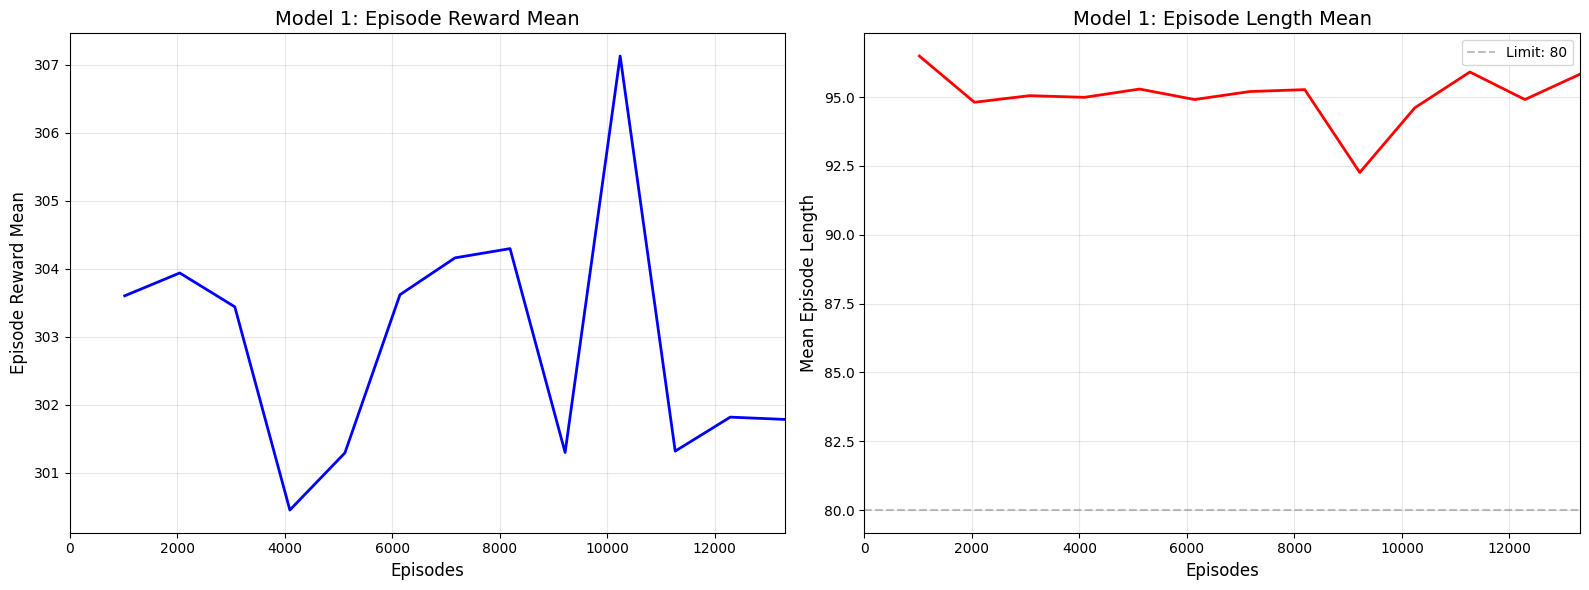

✓ Plots saved as 'Model_1_training_curves.png'
  Total episodes: 13312
  Final reward: 301.78
  Final length: 95.83


In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import os
import matplotlib.pyplot as plt
import numpy as np

def load_tensorboard_data(log_dir):
    """Extracts training data from TensorBoard logs"""
    
    #most recent log directory
    subdirs = [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
    if not subdirs:
        print(f"No subdirectories found in {log_dir}")
        return None, None, None
    
    latest_dir = sorted(subdirs)[-1]
    full_path = os.path.join(log_dir, latest_dir)
    
    print(f"Loading from: {full_path}")

    ea = event_accumulator.EventAccumulator(full_path)
    ea.Reload()

    print("Available tags:", ea.Tags()['scalars'])
    try:
        reward_data = ea.Scalars('rollout/ep_rew_mean')
        length_data = ea.Scalars('rollout/ep_len_mean')
        
        timesteps = [x.step for x in reward_data]
        rewards = [x.value for x in reward_data]
        lengths = [x.value for x in length_data]
        
        return timesteps, rewards, lengths
    except KeyError as e:
        print(f"Could not find expected scalar tags: {e}")
        return None, None, None

def plot_from_tensorboard(log_dir, model_name="Model 1", num_envs=16, episode_limit=80):
    """Creates styled plots from TensorBoard logs"""
    
    timesteps, rewards, lengths = load_tensorboard_data(log_dir)
    
    if timesteps is None:
        print("Failed to load data")
        return
    
    #timesteps to approx episodes
    episodes = np.array(timesteps) // num_envs
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    #reward
    ax1.plot(episodes, rewards, 'b-', linewidth=2)
    ax1.set_title(f"{model_name}: Episode Reward Mean", fontsize=14)
    ax1.set_xlabel("Episodes", fontsize=12)
    ax1.set_ylabel("Episode Reward Mean", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, episodes[-1])
    
    #length
    ax2.plot(episodes, lengths, 'r-', linewidth=2)
    ax2.set_title(f"{model_name}: Episode Length Mean", fontsize=14)
    ax2.set_xlabel("Episodes", fontsize=12)
    ax2.set_ylabel("Mean Episode Length", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, episodes[-1])
    ax2.axhline(y=episode_limit, color='gray', linestyle='--', alpha=0.5, label=f'Limit: {episode_limit}')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f"{model_name.replace(' ', '_')}_training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plots saved as '{model_name.replace(' ', '_')}_training_curves.png'")
    print(f"  Total episodes: {episodes[-1]}")
    print(f"  Final reward: {rewards[-1]:.2f}")
    print(f"  Final length: {lengths[-1]:.2f}")

# Use it:
plot_from_tensorboard("./ppo_battleship_log/", model_name="Model 1", num_envs=16, episode_limit=80)